#### 0) Lectura de datos

In [15]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects
from skimage.measure import label

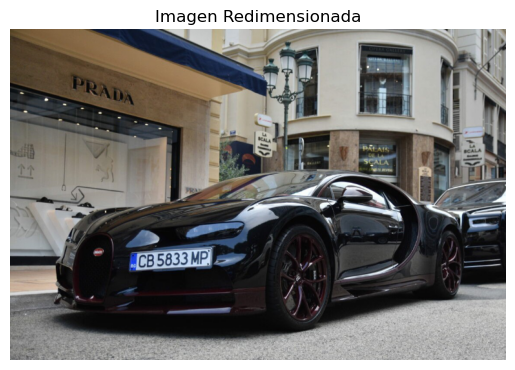

In [16]:
# Cargar la imagen 'auto_1.jpg' con opencv
imagen  = cv2.imread('auto_1.jpg')

# Convertir la imagen a formato RGB
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Redimensionar la imagen mediante el método de opencv "resize()" a un tamaño de (768,512)
imagen_redim = cv2.resize(imagen_rgb, (768,512))

# Visualizar la imagen
plt.imshow(imagen_redim)
plt.axis('off')  # Ocultar los ejes
plt.title("Imagen Redimensionada")
plt.show()

#### 1) Detección de bordes con Canny

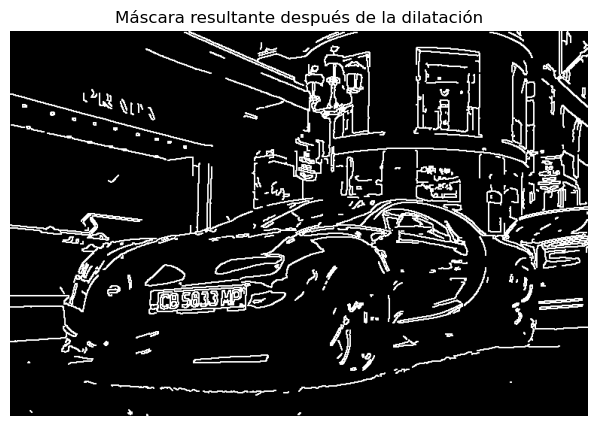

In [17]:
# Convertir a escala de grises
imagen_gray = cv2.cvtColor(imagen_redim, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano con un kernel de 3x3
gaussian_blur = cv2.GaussianBlur(imagen_gray, (3, 3), 0)

# Aplicar el método de Canny para la detección de bordes
edges = cv2.Canny(gaussian_blur, 150, 200)

# Crear un kernel para la dilatación 2x2
kernel = np.ones((2, 2))

# Aplicar una dilatación con un kernel de 2x2 y 1 iteración
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

# Mostrar la imagen resultante
plt.figure(figsize=(10, 5))
plt.imshow(dilated_edges, cmap='gray')
plt.axis('off')
plt.title('Máscara resultante después de la dilatación')
plt.show()




#### 2) Procesamiento mediante operaciones morfológicas

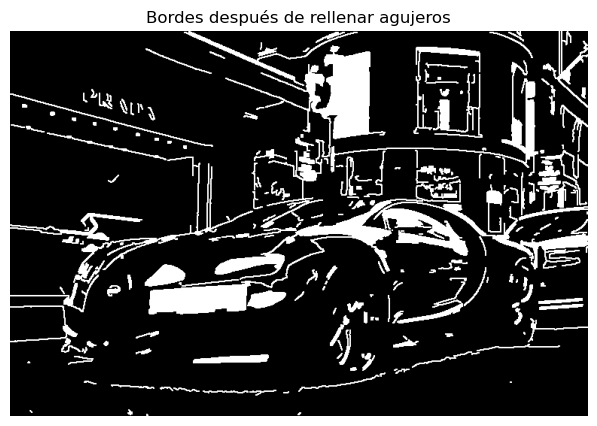

In [19]:
# Aplicar el comando "binary_fill_holes" sobre los bordes detectados.
# Nota: convertir la imagen a formato "uint8"
filled_edges = binary_fill_holes(dilated_edges)
filled_edges = filled_edges.astype(np.uint8)

# Aplicar una apertura en el eje vertical con un kernel de 20x1 y 1 iteración para eliminar bordes verticales. 
# Nota: Aplicar el método de opencv "mophologyEx()" con cv2.MORPH_OPEN. 

# Aplicar una apertura en el eje horizontal con un kernel de 1x20 y 1 iteración para eliminar bordes horizontales

# Eliminar artefactos, es decir, objetos cuya área tenga menos de 1000 píxeles con una connectivity=8.  
# Nota: utilizar el método "remove_small_objects()" sobre la máscara anterior en formato booleano. 

# Convertir la máscara resultante a formato uint8

# Visualizar la máscara resultante

# Rellenar los agujeros en los bordes detectados
filled_edges = binary_fill_holes(dilated_edges)
filled_edges = (filled_edges.astype(np.uint8) * 255)
# Visualizar imagen después de rellenar agujeros
plt.figure(figsize=(10, 5))
plt.imshow(filled_edges, cmap='gray')
plt.title('Bordes después de rellenar agujeros')
plt.axis('off')
plt.show()



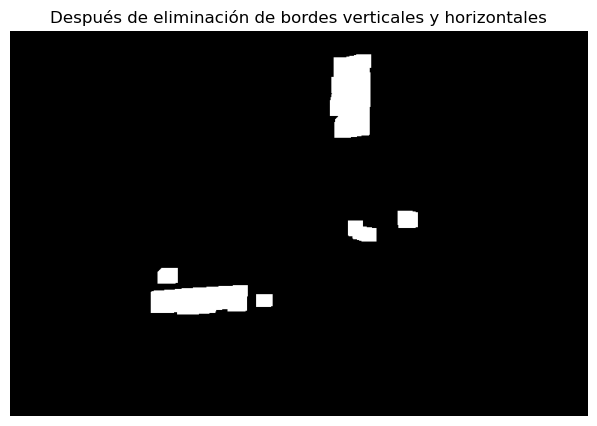

In [88]:
# Crear kernels para apertura en vertical y horizontal
kernel_vertical = np.ones((20, 1), np.uint8)
kernel_horizontal = np.ones((1, 20), np.uint8)

# Aplicar apertura en el eje vertical para eliminar bordes verticales
opened_vertical = cv2.morphologyEx(filled_edges, cv2.MORPH_OPEN, kernel_vertical, iterations=1)

# Aplicar apertura en el eje horizontal para eliminar bordes horizontales
opened_horizontal = cv2.morphologyEx(opened_vertical, cv2.MORPH_OPEN, kernel_horizontal, iterations=1)



# Visualizar imagen después de operaciones morfológicas
plt.figure(figsize=(10, 5))
plt.imshow(opened_horizontal, cmap='gray')
plt.title('Después de eliminación de bordes verticales y horizontales')
plt.axis('off')
plt.show()



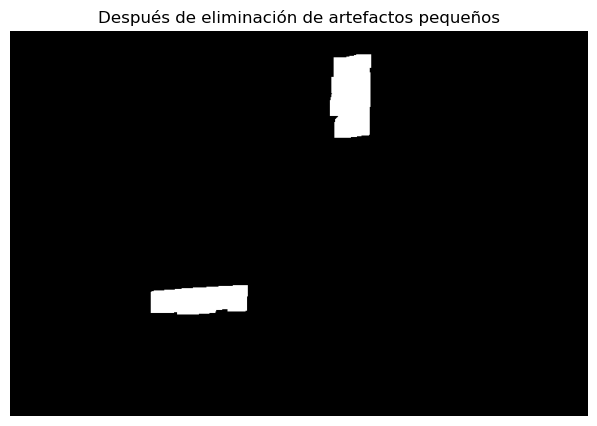

In [89]:
# Eliminar artefactos, es decir, objetos cuya área tenga menos de 1000 píxeles con una connectivity=8.  
# Nota: utilizar el método "remove_small_objects()" sobre la máscara anterior en formato booleano. 

# Convertir la imagen a formato booleano (True/False) para usar remove_small_objects()
binary_mask_bool = opened_horizontal.astype(bool)

# Remover objetos pequeños (área menor a 1000 píxeles) con conectividad 8
cleaned_mask = remove_small_objects(binary_mask_bool, min_size=1000, connectivity=8)

# Convertir la máscara de vuelta a uint8 para visualizarla
cleaned_mask_uint8 = (cleaned_mask * 255).astype(np.uint8)

# Visualizar imagen después de eliminación de artefactos
plt.figure(figsize=(10, 5))
plt.imshow(cleaned_mask_uint8, cmap='gray')
plt.title('Después de eliminación de artefactos pequeños')
plt.axis('off')
plt.show()

2


IndexError: index 1 is out of bounds for axis 1 with size 1

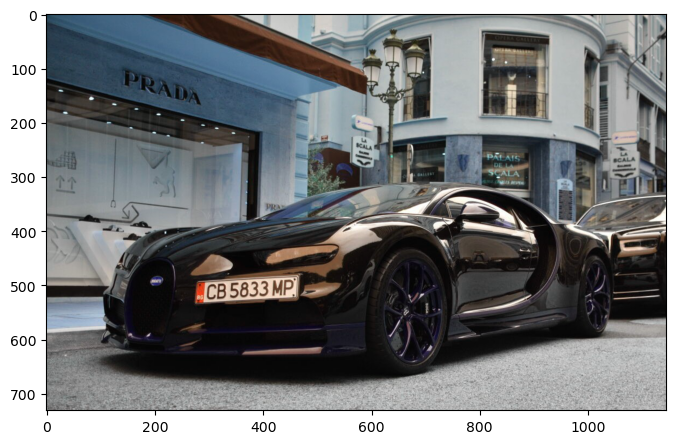

In [90]:
# Label connected components
labeled_image = label(cleaned_mask_uint8)

aspect_ratios = {}
for region in regionprops(labeled_image):
    if region.major_axis_length > 0:  # Avoid division by zero
        aspect_ratio = region.minor_axis_length / region.major_axis_length
        aspect_ratios[region.label] = aspect_ratio

# Find the object with the smallest aspect ratio
min_ratio_label = min(aspect_ratios, key=aspect_ratios.get)
print(min_ratio_label)

# Generate a mask for the object with the smallest aspect ratio
mask = labeled_image == min_ratio_label


# # Find contours of the selected object
# contours = find_contours(mask, 0.5)

# Plot the original image with detected contours
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image, cmap='gray')

# Draw the contours in red
for contour in contours:
    rr, cc = contour[:, 0].astype(int), contour[:, 1].astype(int)
    ax.plot(cc, rr, '-r', linewidth=2)

plt.title("Object with the Smallest Aspect Ratio")
plt.show()

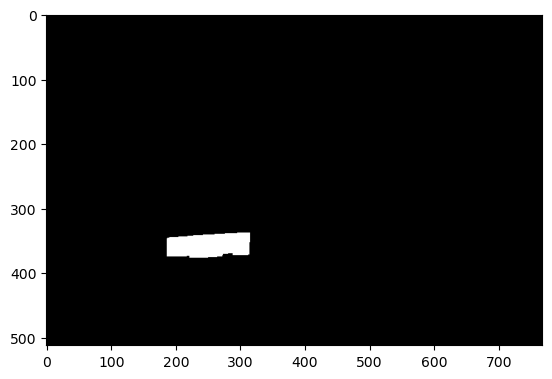

In [91]:
# Podemos acceder de manera independiente al objeto que nos interese a partir de su etiqueta correspondiente
# Crear una imagen de etiquetas mediante "label"
lab, num = label(cleaned_mask_uint8, return_num=True)
regions = regionprops(lab)
objeto = lab == 2
objeto = objeto.astype('uint8')
plt.imshow(objeto, cmap='gray')
plt.show()

(338, 187, 377, 316)


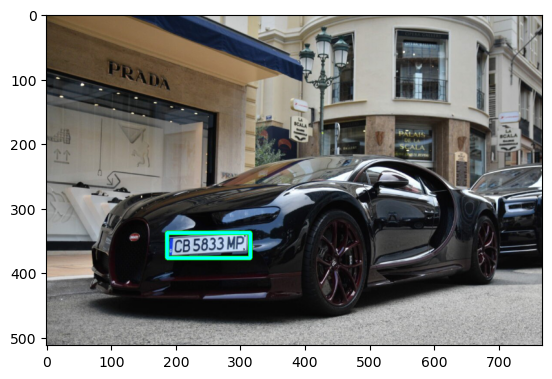

In [92]:
from skimage.measure import regionprops
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

# Después, podemos extraer la bounding box de dicho objeto
prop = regionprops(objeto)
bbox = prop[0].bbox
print(bbox)
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(imagen_redim.copy(), start_point, end_point, (0, 255, 255), 3)
                     
plt.imshow(window, cmap='gray')
plt.show()

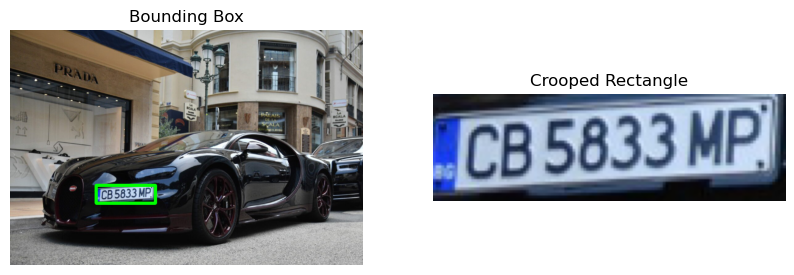

In [27]:
# Extract bounding box coordinates
min_row, min_col, max_row, max_col = bbox

# Define the four source points (bounding box corners)
src_pts = np.array([
    [min_col, min_row],  # Top-left
    [max_col, min_row],  # Top-right
    [max_col, max_row],  # Bottom-right
    [min_col, max_row]   # Bottom-left
], dtype=np.float32)

# Define the destination points for a perfect rectangle
width = max_col - min_col
height = max_row - min_row
dst_pts = np.array([
    [0, 0],           # Top-left
    [width, 0],       # Top-right
    [width, height],  # Bottom-right
    [0, height]       # Bottom-left
], dtype=np.float32)

# Compute the perspective transformation matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Apply perspective warp to get a rectified output
warped = cv2.warpPerspective(imagen_redim, M, (width, height))

# Visualize Results
plt.figure(figsize=(10, 5))

# Show bounding box on the original image
window = cv2.rectangle(imagen_redim, (min_col, min_row), (max_col, max_row), (0, 255, 0), 5)
plt.subplot(1, 2, 1)
plt.imshow(window)
plt.title("Bounding Box")
plt.axis("off")

# Show the rectified (warped) image
plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title("Crooped Rectangle")
plt.axis("off")

plt.show()

In [38]:
# # Run Tesseract OCR on the processed image
# import pytesseract
# custom_config = r'--oem 3 --psm 6'  # OCR Engine Mode (oem) and Page Segmentation Mode (psm)
# text = pytesseract.image_to_string(warped, config=custom_config)

# # Clean the extracted text
# text = text.strip().replace("\n", "")

# print(f"Extracted License Plate Text: {text}")

#### 3) Detección automática de la región de interés correspondiente a la matrícula

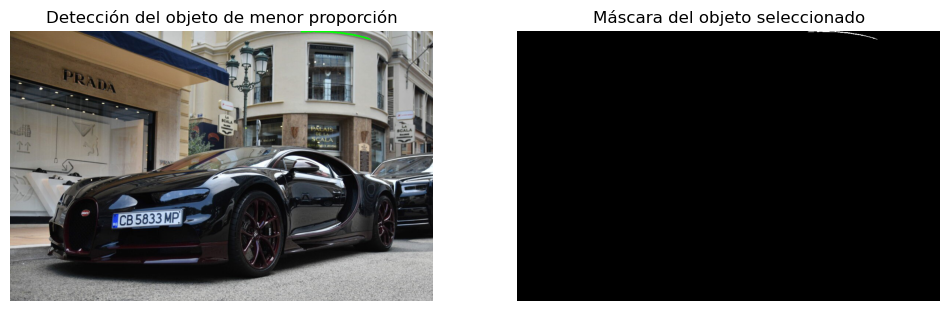

In [44]:
# Crear una imagen de etiquetas mediante el comando "label"

# Calcular la proporción (cociente) entre el minor_axis_length y el major_axis_length para cada objeto de la imagen de etiquetas

# Generar una máscara que contenga únicamente el objeto de la menor proporción. 

# Dibujar los contornos de la máscara sobre la imagen original y visualizar el resultado


# Crear una imagen de etiquetas mediante "label"
lab, num = label(cleaned_mask_uint8, return_num=True)
regions = regionprops(lab)

# Calcular la proporción (minor_axis_length / major_axis_length) y encontrar la menor
min_ratio = float('inf')
best_region = None

for region in regions:
    if region.major_axis_length > 0:  # Evitar divisiones por cero
        ratio = region.minor_axis_length / region.major_axis_length
        if ratio < min_ratio:
            min_ratio = ratio
            best_region = region

# Generar una máscara que contenga únicamente el objeto de la menor proporción
if best_region:
    minr, minc, maxr, maxc = best_region.bbox
    mask = (labeled_mask == best_region.label).astype(np.uint8) * 255

    # Dibujar los contornos sobre la imagen original
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

    # Mostrar la imagen con la detección
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title("Detección del objeto de menor proporción")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Máscara del objeto seleccionado")
    plt.axis('off')

    plt.show()
else:
    print("No se encontró ninguna región válida en la imagen.")


C:\Users\aitan\AppData\Local\Temp\ipykernel_19708\3041847413.py:36: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # Convertir a enteros


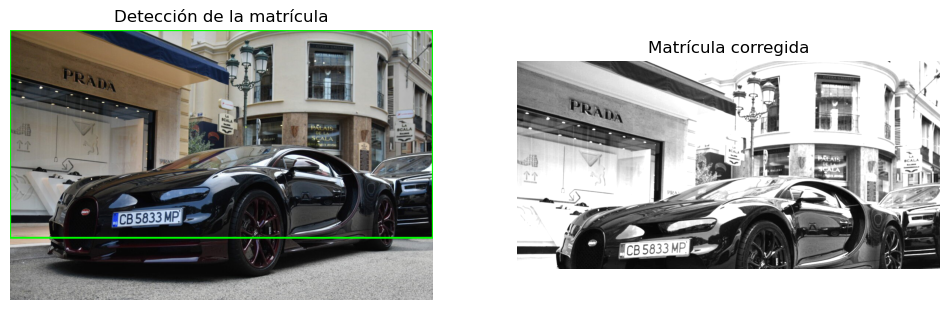

In [30]:
# Cargar la imagen
image_path = "auto_1.jpg"  # Asegúrate de cambiar esto si el nombre del archivo es diferente
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro Gaussiano para reducir ruido
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# Aplicar Canny para detección de bordes
edges = cv2.Canny(blurred, 100, 200)

# Dilatación para conectar bordes de la matrícula
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)

# Encontrar contornos en la imagen procesada
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos basados en relación de aspecto típica de matrículas
possible_plates = []
for cnt in contours:
    rect = cv2.minAreaRect(cnt)  # Encuentra un rectángulo rotado que encierra el contorno
    width, height = rect[1]  # Dimensiones del rectángulo
    aspect_ratio = max(width, height) / min(width, height)  # Relación de aspecto
    
    if 2.0 < aspect_ratio < 6.0:  # Las matrículas suelen ser más anchas que altas
        possible_plates.append(rect)

# Seleccionar la mejor detección (la de mayor área)
if possible_plates:
    best_plate = max(possible_plates, key=lambda r: r[1][0] * r[1][1])  # Escoge el de mayor área

    # Obtener las coordenadas de la caja rotada
    box = cv2.boxPoints(best_plate)
    box = np.int0(box)  # Convertir a enteros
    
    # Dibujar la detección en la imagen original
    image_with_box = image.copy()
    cv2.drawContours(image_with_box, [box], 0, (0, 255, 0), 3)  # Dibuja el rectángulo

    # Ordenar puntos para la transformación de perspectiva
    rect = np.zeros((4, 2), dtype="float32")
    s = box.sum(axis=1)
    rect[0] = box[np.argmin(s)]  # Esquina superior izquierda
    rect[2] = box[np.argmax(s)]  # Esquina inferior derecha
    diff = np.diff(box, axis=1)
    rect[1] = box[np.argmin(diff)]  # Esquina superior derecha
    rect[3] = box[np.argmax(diff)]  # Esquina inferior izquierda

    # Definir la transformación de perspectiva
    (tl, tr, br, bl) = rect
    width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
    height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (width, height))

    # Convertir a escala de grises y aumentar el contraste
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    contrast_enhanced = cv2.convertScaleAbs(warped_gray, alpha=1.5, beta=50)

    # Mostrar la imagen con la detección de la matrícula
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
    plt.title("Detección de la matrícula")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(contrast_enhanced, cmap='gray')
    plt.title("Matrícula corregida")
    plt.axis('off')

    plt.show()
else:
    print("No se encontró ninguna matrícula en la imagen.")

(730, 993, 731, 994)


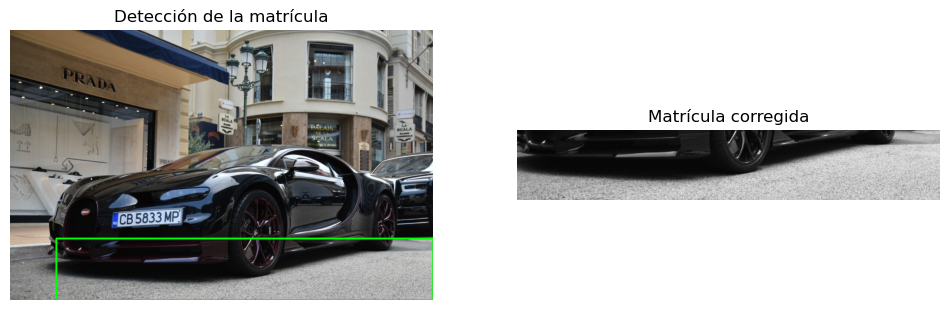

In [37]:
# Cargar la imagen
image_path = "auto_1.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar un umbral adaptativo para detectar regiones claras
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Etiquetar regiones conectadas
labeled_mask = label(binary)


# Filtrar regiones por tamaño y relación de aspecto
regions = regionprops(labeled_mask)
print(region.bbox)

# Encontrar la región blanca más grande con forma de matrícula
best_region = None
max_area = 0

for region in regions:
    minr, minc, maxr, maxc = region.bbox
    width = maxc - minc
    height = maxr - minr
    aspect_ratio = width / height  # Relación de aspecto (ancho/alto)

    if 2.5 < aspect_ratio < 6.5 and width * height > max_area:
        best_region = region
        max_area = width * height

# Si se encuentra una matrícula, extraerla
if best_region:
    minr, minc, maxr, maxc = best_region.bbox
    license_plate = image[minr:maxr, minc:maxc]  # Extraer la región de interés

    # Dibujar rectángulo en la imagen original
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (minc, minr), (maxc, maxr), (0, 255, 0), 3)

    # Mostrar la detección
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
    plt.title("Detección de la matrícula")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.title("Matrícula corregida")
    plt.axis('off')

    plt.show()
else:
    print("No se encontró ninguna matrícula en la imagen.")

NameError: name 'imutils' is not defined

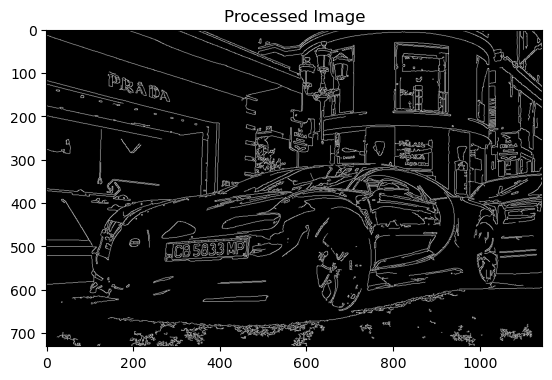

In [53]:
# Cargar la imagen
image_path = "auto_1.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB)) #show processed image
plt.title('Processed Image')

edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Find contours 
contours = imutils.grab_contours(keypoints) #Grab contours 
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] #Sort contours


# # Mostrar la detección
# plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
#     plt.title("Detección de la matrícula")
#     plt.axis('off')

# Crear una imagen de etiquetas mediante "label"
labeled_mask = label(binary)
regions = regionprops(labeled_mask)


# Calcular la proporción (minor_axis_length / major_axis_length) y encontrar la menor
min_ratio = float('inf')
best_region = None

for region in regions:
    if region.major_axis_length > 0:  # Evitar divisiones por cero
        ratio = region.minor_axis_length / region.major_axis_length
        if ratio < min_ratio:
            min_ratio = ratio
            best_region = region

# Generar una máscara que contenga únicamente el objeto de la menor proporción
if best_region:
    minr, minc, maxr, maxc = best_region.bbox
    mask = (labeled_mask == best_region.label).astype(np.uint8) * 255

    # Dibujar los contornos sobre la imagen original
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

    # Mostrar la imagen con la detección
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title("Detección del objeto de menor proporción")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Máscara del objeto seleccionado")
    plt.axis('off')

    plt.show()
else:
    print("No se encontró ninguna región válida en la imagen.")

#### 4) Procesamiento de la región de interés

In [ ]:
# Calcular la boundingbox de la máscara

# Hacer un crop de la imagen original a partir de las coordenadas de la boundingbox

# Calcular la orientación de la máscara. 

# Hacer una conversión mediante la siguiente fórmula:
    # angle = (orientation*90)/(math.pi/2). Nota: utilizar "import math"
    # Si 'angle' es mayor que 0, la orientación será igual a 90-angle
    # Si no, la orientación será igual a -(90+angle)

# Aplicar una transformación geométrica de rotación para orientar horizontalmente el crop de la imagen obtenido anteriormente

# Aumentar el contraste 100 unidades de acuerdo a la fórmula vista en clase. 

# Visualizar el resultado la matrícula con el contraste aumentado


#### 5) Convertir el contenido de la imagen en un string mediante la librería 'pytesseract'
Para instalar la librería pytesseract:
    
    Descargar el ejecutable en -->  https://github.com/UB-Mannheim/tesseract/wiki
    Instalar la librería haciendo --> pip install pytesseract

Si se tienen dudas, consultar el siguiente vídeo:

    https://www.youtube.com/watch?v=_j6o2rBkhhg

In [ ]:
# Crear la ruta de pytesseract que contenga el ejecutable

# Convertir el contenido de la imagen en una variable de tipo string.
# Importante: utiliza la opción --> config='--psm 10'

# Eliminar del string los caracteres especiales mediante la siguiente línea de código:
# string = ''.join(filter(str.isalnum, string))

# Visualizar la imagen original y ponle el título extraído automáticamente mediante la librería "pytesseract"


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops

# Cargar la imagen
image_path = "auto_1.jpg"  # Asegúrate de cambiar esto si el nombre del archivo es diferente
image = cv2.imread(image_path)

# Convertir a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano con un kernel de 3x3
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# Aplicar el método de Canny para la detección de bordes
edges = cv2.Canny(blurred, 100, 200)

# Rellenar los agujeros en los bordes detectados
filled_edges = binary_fill_holes(edges > 0).astype(np.uint8) * 255

# Aplicar apertura morfológica
kernel_vertical = np.ones((20, 1), np.uint8)
kernel_horizontal = np.ones((1, 20), np.uint8)
opened_vertical = cv2.morphologyEx(filled_edges, cv2.MORPH_OPEN, kernel_vertical, iterations=1)
opened_horizontal = cv2.morphologyEx(opened_vertical, cv2.MORPH_OPEN, kernel_horizontal, iterations=1)

# Eliminar artefactos pequeños
binary_mask = opened_horizontal > 0
mask_cleaned = remove_small_objects(binary_mask, min_size=1000, connectivity=8).astype(np.uint8) * 255

# Crear imagen de etiquetas
labeled_mask = label(mask_cleaned)
regions = regionprops(labeled_mask)

# Calcular la proporción entre el minor_axis_length y el major_axis_length
if regions:
    smallest_region = min(regions, key=lambda r: (r.minor_axis_length / r.major_axis_length))
    selected_mask = (labeled_mask == smallest_region.label).astype(np.uint8) * 255
else:
    selected_mask = np.zeros_like(mask_cleaned)  # Si no hay regiones, devuelve una máscara vacía

# Encontrar contornos y calcular la bounding box
contours, _ = cv2.findContours(selected_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    x, y, w, h = cv2.boundingRect(contours[0])
    cropped_plate = image[y:y+h, x:x+w]

    # Calcular la orientación
    moments = cv2.moments(selected_mask)
    orientation = 0.5 * math.atan2(2 * moments["mu11"], (moments["mu20"] - moments["mu02"]))
    angle = (orientation * 90) / (math.pi / 2)
    oriented_angle = 90 - angle if angle > 0 else -(90 + angle)

    # Rotar la imagen para alinear la matrícula
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, oriented_angle, 1.0)
    rotated_plate = cv2.warpAffine(cropped_plate, rotation_matrix, (w, h))

    # Aumentar el contraste
    contrast_enhanced = cv2.convertScaleAbs(rotated_plate, alpha=1.5, beta=100)

    # Visualizar la imagen con la matrícula extraída
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(contrast_enhanced, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Matrícula detectada")
    plt.show()
else:
    print("No se encontró ninguna matrícula en la imagen.")